# 4. 인공 신경망

인공 신경망은 사람의 신경망을 모사하여 만든 예측 도구이다. 기본적으로 하나의 레이어에 다수의 노드를 가지고 있으며 여러 개의 레이어가 쌓인 신경망을
깊은 신경망이라고 한다. 이 때, 깊은 신경망을 이용하여 모델을 학습 시키는 방법을 딥러닝이라고 한다.

In [2]:
# sklearn.datasets에서는 다양한 데이터들을 제공한다.
# https://scikit-learn.org/stable/datasets/index.html

from sklearn.datasets import load_boston # 보스턴 집 값 데이터를 불러온다.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
from sklearn.preprocessing import MinMaxScaler # 데이터 내의 값을 0이상 1이하의 값으로 조정

# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)

from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Loss
from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

# Plot
import matplotlib.pyplot as plt # 시각화 도구

## 4.1 데이터 불러오기

In [3]:
bos = load_boston() # 데이터 불러오기

In [4]:
# bos 내에는 data, feature name 등 다양한 정보를 포함하고 있다.
df = pd.DataFrame(bos.data) # 데이터의 변수를 데이터프레임으로 만들기 
df.columns = bos.feature_names # 데이터 변수명 불러오기
df['Price'] = bos.target # 집 값에 해당하는 타겟 값 불러오기

# 데이터프레임 보여주기
# df.head()는 상위 5줄만 보여준다.
# df.head(10) 괄호 안에 숫자 10을 넣으면 10줄을 보여준다. 
df.head(10) 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [5]:
"""
** 데이터 변수 설명 **

CRIM: 범죄율
INDUS: 비소매상업지역 면적 비율
NOX: 일산화질소 농도
RM: 주택당 방 수
LSTAT: 인구 중 하위 계층 비율
B: 인구 중 흑인 비율
PTRATIO: 학생/교사 비율
ZN: 25,000 평방피트를 초과 거주지역 비율
CHAS: 찰스강의 경계에 위치한 경우는 1, 아니면 0
AGE: 1940년 이전에 건축된 주택의 비율
RAD: 방사형 고속도로까지의 거리
DIS: 직업센터의 거리
TAX: 재산세율
"""
print("Description in Korean")

Description in Korean


## 4.2 목표 성능 설정

In [6]:
# 우리가 만든 인공 신경망의 성능이 어느 정도인지 판단하기 위해 베이스라인을 정해보자.
# Multithreaded Local Learning Regularization Neural Networks for Regression Tasks, 2015
# 위 논문에서 보스턴 집 값 예측의 성능은 RMSE=0.08019이다.
# 따라서 실험 조건을 동일하게 하고 RMSE를 측정하여 아래 정의 된 인공 신경망의 성능을 확인하자.
print("RMSE: 0.08019")

RMSE: 0.08019


## 4.3 데이터 스케일링(MinMax Scale)

In [7]:
# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임에서 타겟값(Price)을 제외하고 넘파이 배열로 만들기
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기

# 데이터 스케일링
# sklearn에서 제공하는 MinMaxScaler 
# (X-min(X))/(max(X)-min(X))을 계산
scaler = MinMaxScaler() 
scaler.fit(X) 
X = scaler.transform(X)

scaler.fit(Y)
Y = scaler.transform(Y)

## 4.4 텐서 데이터와 배치 만들기

In [8]:
# 텐서 데이터로 변환하는 클래스(3강 참고)
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [9]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
# 기준으로 잡은 논문이 전체 데이터를 50%, 50%로 나눴기 때문에 test size를 0.5로 설정한다.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

## 4.5 모델 구축

모델은 Regressor로 정의하며 입력층(노드 13개), 2개의 은닉층(50, 30개), 출력층(1개)으로 구성한다. 데이터의 변수는 13개이므로 입력층의 노드는
13개가 되고 출력층은 집 값인 단일 값을 추출하는 것이므로 1개가 된다. 은닉층에 대해서는 실험을 하면서 튜닝할 수 있다.

In [11]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x
    
# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

## 4.6 모델, 손실함수, 최적화 방법 선언

In [12]:
model = Regressor()
criterion = nn.MSELoss()

# lr은 학습률이다.
# weight_decay는 L2 정규화에서의 penalty 정도를 의미한다.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

## 4.7 학습 진행

In [13]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader)

for epoch in range(400): # 400번 학습을 진행한다.

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개 데이터가 있는 배치가 하나 씩 들어온다.

        inputs, values = data # data에는 X, Y가 들어있다.

        optimizer.zero_grad() # 최적화 초기화
        
        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        loss = criterion(outputs, values) # 손실 함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정 
        optimizer.step() # 역전파를 진행하고 가중치 업데이트
        
        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
 

    loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

        
print('Finished Training')

Finished Training


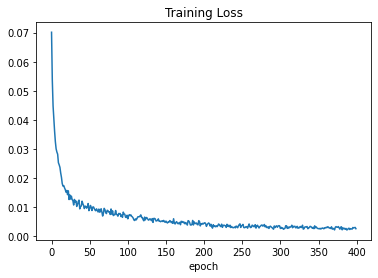

In [14]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 4.8 모델 평가

In [15]:
def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서
    actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서
        
    with torch.no_grad():
        model.eval() # 평가를 할 때에는 .eval() 반드시 사용해야 한다.
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0) # cat을 통해 예측값을 누적
            actual = torch.cat((actual, values), 0) # cat을 통해 실제값을 누적
    
    predictions = predictions.numpy() # 넘파이 배열로 변경
    actual = actual.numpy() # 넘파이 배열로 변경
    rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용하여 RMSE 계산
    
    return rmse  

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 온전한 모델로 평가를 해야하는데 .eval()이 아닌 .train()인 경우 드랍아웃이 활성화 되어 있다.
# 따라서 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들을 평가 시에는 비활성화 해야만 한다.

In [16]:
train_rmse = evaluation(trainloader) # 학습 데이터의 RMSE
test_rmse = evaluation(testloader) # 시험 데이터의 RMSE

print("Train RMSE: ",train_rmse)
print("Test RMSE: ",test_rmse)

# 예시를 위한 단순 비교입니다. 실제 연구에서는 디테일한 비교가 필요합니다.
# 비교 논문에서는 20번의 평가 결과의 평균으로 결과값을 산정 했습니다.
# 데이터를 무작위로 나누고 모델의 초기값도 random initial parameter를 사용했기 때문에 학습을 할 때 마다 결과가 다르게 나올 수 있습니다.
# 이 강의에서는 학습의 흐름(for문)과 모델(Regressor) 부분을 주의 깊게 보시면 됩니다.

Train RMSE:  0.039059013
Test RMSE:  0.07430778


In [17]:
# Multithreaded Local Learning Regularization Neural Networks for Regression Tasks, 2015
print("RMSE: 0.08019")

RMSE: 0.08019
